# Predict Gene Commision number
### or 0 if gene is not an enzyme

# Predict Gene Commision number
## Visualize Attention map
#### Author: Fridman Naomi
#### Date: 2025-03-2
> transformer-based-enzyme-classification/blob/main/predict_is_gene_an_anzyme.ipynb

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/naomifridman/transformer-based-enzyme-classification/blob/main/predict_enzyme_commision_number.ipynb)

In [ ]:
# Check if running in Google Colab

if 'google.colab' in str(get_ipython()):
    print("Running in Google Colab")
    # Clone the repository
    !git clone https://github.com/naomifridman/transformer-based-enzyme-classification.git

    # Change to the repository directory
    os.chdir('/content/transformer-based-enzyme-classification')
    !wget https://zenodo.org/records/15640615/files/gmodels.tar.gz
    !tar xvfz models.tar.gz

In [102]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import utils as u

# Model upload
> Just run the cell

In [103]:
# ESM2 Sequence Classification
# Interactive protein sequence classification using ESM2

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ============================================================================
# 🔧 SETUP AND MODEL LOADING
# ============================================================================

print("🧬 ESM2 Sequence Classification Tool")
print("="*60)

# Device setup
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"📱 Using device: {device}")

# Model setup
model_checkpoint = "facebook/esm2_t12_35M_UR50D"
num_labels = 7

print("⏳ Loading model...")
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Load saved state dict and move to device
saved_state_dict = torch.load("./models/esn2_model_predict_egene_ec1.pth", map_location=device)
model.load_state_dict(saved_state_dict)
model.to(device)
model.eval()

print("✅ Model loaded successfully!")

🧬 ESM2 Sequence Classification Tool
📱 Using device: cuda
⏳ Loading model...


Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded successfully!


## Input Sequances
> copy your sequances into sequence_1,sequence_2,sequence_3,sequence_4,sequence_5
> 
> leave "" for empty sequance

In [104]:
# ============================================================================
# 📝 SEQUENCE INPUT
# ============================================================================


sequence_1 = "MHNKIVRIASSALTGGKLLEKLKPLTRWEVQWDPNKTKCLGITREVTFKDYETTWAFLTRVSMRSHLWGHHPLIHTSYTWVKLELHTHDIDPKDGAHSQLSDIDVRMAKRIDSYIDEMTT" #P38744
sequence_2 = "MTEKHKTMGKFKVIVLAGTAGTGKSTIAGELIHEFKDIYPDLKFIEGDDLHPPANVEKMTRGIPLNDDDRWDWLKKVAVESTKAAASTKEHLSIVACSSLKKKYRDLIRHTCPESEFHFIFLYASKIEVLKRLKTRKGHFMKADMMESQFRDLELPDINDETDCDIVPLDFKTFYQIEKDVIQVVKSKVLNIE" #@param {type:"string"}
sequence_3 = "MQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGG" 
sequence_4 = "" 
sequence_5 = "" 

## Predict Is Enzyne ?
> Just run the cell

In [105]:
show_plots = False 
save_results = True 

# Process sequences
raw_sequences = [sequence_1, sequence_2, sequence_3, sequence_4, sequence_5]
sequences = [seq.strip().replace(' ', '').replace('\n', '').upper() for seq in raw_sequences if seq.strip()]
print(f"\n📊 Found {len(sequences)} sequence(s) to analyze:")
for i, seq in enumerate(sequences):
    print(f"  • Sequence {i+1}: {len(seq)} amino acids")
    if len(seq) > 60:
        print(f"    Preview: {seq[:30]}...{seq[-30:]}")
    else:
        print(f"    Sequence: {seq}")

if not sequences:
    print("⚠️ No sequences provided. Please enter at least one sequence above.")
else:
    # ============================================================================
    # 🔮 PREDICTION
    # ============================================================================
    
    print(f"\n🧠 Running ESM2 classification...")
    
    # Tokenize sequences
    tokenized = tokenizer(sequences, max_length=512, padding=True, truncation=True, return_tensors='pt')
    
    # Move tokenized data to device
    tokenized = {key: val.to(device) for key, val in tokenized.items()}
    
    # Make predictions
    with torch.no_grad():
        outputs = model(**tokenized)
    
    # Calculate probabilities and predictions
    softmax = torch.nn.Softmax(dim=1)
    probs = softmax(outputs.logits)
    pred_class = torch.argmax(probs, dim=1)
    
    # Convert to numpy
    probs_np = probs.cpu().numpy()
    pred_class_np = pred_class.cpu().numpy()
    
    print("✅ Predictions completed!")
    
    # ============================================================================
    # 📊 RESULTS
    # ============================================================================
    
    # Define class labels for 7 classes (adjust these based on your model)
    class_labels = {
        0: "Class 0 - Non-Enzyme",
        1: "Class 1 - Oxidoreductase", 
        2: "Class 2 - Transferase",
        3: "Class 3 - Hydrolase",
        4: "Class 4 - Lyase",
        5: "Class 5 - Isomerase",
        6: "Class 6 - Ligase"
    }
    
    # Create results table
    print(f"\n{'='*80}")
    print("🎯 CLASSIFICATION RESULTS")
    print(f"{'='*80}")
    
    results_data = []
    for i, (seq, pred, prob_all) in enumerate(zip(sequences, pred_class_np, probs_np)):
        confidence = max(prob_all)
        
        print(f"\n🧬 Sequence {i+1}:")
        print(f"   Length: {len(seq)} amino acids")
        print(f"   Prediction: {class_labels.get(pred, f'Class {pred}')}")
        print(f"   Confidence: {confidence:.4f}")
        
        # Show probabilities for all 7 classes
        prob_str = " | ".join([f"Class {j}: {prob_all[j]:.4f}" for j in range(len(prob_all))])
        print(f"   Probabilities: {prob_str}")
        
        # Determine prediction interpretation
        if pred == 0:
            interpretation = "Non-Enzyme" if confidence > 0.7 else "Likely Non-Enzyme"
        else:
            enzyme_type = class_labels.get(pred, f"Enzyme Class {pred}").split(" - ")[-1]
            interpretation = enzyme_type if confidence > 0.7 else f"Likely {enzyme_type}"
        
        print(f"   Interpretation: {interpretation}")
        
        # Create result dictionary
        result_dict = {
            'Sequence_ID': f'Seq_{i+1}',
            'Length': len(seq),
            'Predicted_Class': int(pred),
            'Predicted_Label': class_labels.get(pred, f'Class {pred}'),
            'Confidence': f"{confidence:.4f}",
            'Interpretation': interpretation,
            'Sequence': seq[:100] + '...' if len(seq) > 100 else seq
        }
        
        # Add individual class probabilities
        for j in range(len(prob_all)):
            result_dict[f'Class_{j}_Prob'] = f"{prob_all[j]:.4f}"
        
        results_data.append(result_dict)
    
    # Create DataFrame
    results_df = pd.DataFrame(results_data)
    
    print(f"\n📋 SUMMARY TABLE:")
    print("="*80)
    display(results_df[['Sequence_ID', 'Length', 'Predicted_Label', 'Confidence', 'Interpretation']])
    
    # ============================================================================
    # 📊 VISUALIZATION (if enabled)
    # ============================================================================
    
    if show_plots:
        # Plot probability distributions
        fig, axes = plt.subplots(1, len(sequences), figsize=(5*len(sequences), 6))
        if len(sequences) == 1:
            axes = [axes]
        
        for i, (seq_id, probs) in enumerate(zip(range(len(sequences)), probs_np)):
            ax = axes[i] if len(sequences) > 1 else axes[0]
            
            bars = ax.bar(range(len(probs)), probs, color=['red' if j == pred_class_np[i] else 'lightblue' for j in range(len(probs))])
            ax.set_title(f'Sequence {i+1} - Predicted: {class_labels.get(pred_class_np[i], f"Class {pred_class_np[i]}")}')
            ax.set_xlabel('Class')
            ax.set_ylabel('Probability')
            ax.set_xticks(range(len(probs)))
            ax.set_xticklabels([f'C{j}' for j in range(len(probs))], rotation=45)
            ax.set_ylim(0, 1)
            
            # Add probability values on bars
            for bar, prob in zip(bars, probs):
                if prob > 0.05:  # Only show if probability > 5%
                    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                           f'{prob:.3f}', ha='center', va='bottom', fontsize=9)
        
        plt.tight_layout()
        plt.show()


📊 Found 3 sequence(s) to analyze:
  • Sequence 1: 120 amino acids
    Preview: MHNKIVRIASSALTGGKLLEKLKPLTRWEV...DPKDGAHSQLSDIDVRMAKRIDSYIDEMTT
  • Sequence 2: 193 amino acids
    Preview: MTEKHKTMGKFKVIVLAGTAGTGKSTIAGE...CDIVPLDFKTFYQIEKDVIQVVKSKVLNIE
  • Sequence 3: 76 amino acids
    Preview: MQIFVKTLTGKTITLEVEPSDTIENVKAKI...GKQLEDGRTLSDYNIQKESTLHLVLRLRGG

🧠 Running ESM2 classification...
✅ Predictions completed!

🎯 CLASSIFICATION RESULTS

🧬 Sequence 1:
   Length: 120 amino acids
   Prediction: Class 4 - Lyase
   Confidence: 0.9994
   Probabilities: Class 0: 0.0004 | Class 1: 0.0000 | Class 2: 0.0000 | Class 3: 0.0001 | Class 4: 0.9994 | Class 5: 0.0000 | Class 6: 0.0000
   Interpretation: Lyase

🧬 Sequence 2:
   Length: 193 amino acids
   Prediction: Class 2 - Transferase
   Confidence: 0.9987
   Probabilities: Class 0: 0.0007 | Class 1: 0.0000 | Class 2: 0.9987 | Class 3: 0.0004 | Class 4: 0.0001 | Class 5: 0.0000 | Class 6: 0.0000
   Interpretation: Transferase

🧬 Sequence 3:
   

,Sequence_ID,Length,Predicted_Label,Confidence,Interpretation
0,Seq_1,120,Class 4 - Lyase,0.9994,Lyase
1,Seq_2,193,Class 2 - Transferase,0.9987,Transferase
2,Seq_3,76,Class 0 - Non-Enzyme,0.9998,Non-Enzyme


## Save results
> Change 'sequence_classification_results.csv' to you prefared file name

> run the cell to save results

In [106]:
  
    # ============================================================================
    # 💾 SAVE RESULTS
    # ============================================================================
    
    if save_results:
        filename = 'sequence_classification_results.csv'
        results_df.to_csv(filename, index=False)
        print(f"💾 Results saved to {filename}")
    
    # Final summary
    print(f"\n🎉 Analysis Complete!")
    print(f"📊 Processed: {len(sequences)} sequences")
    print(f"🔴 Class 0 predictions: {sum(pred_class_np == 0)}")
    print(f"🔵 Class 1 predictions: {sum(pred_class_np == 1)}")
    
    avg_confidence = np.mean([max(prob) for prob in probs_np])
    print(f"📈 Average confidence: {avg_confidence:.3f}")
    
    print("\n" + "="*60)
    print("🔬 Ready for new sequences! Edit the sequences above and re-run.")
    print("="*60)

💾 Results saved to sequence_classification_results.csv

🎉 Analysis Complete!
📊 Processed: 3 sequences
🔴 Class 0 predictions: 1
🔵 Class 1 predictions: 0
📈 Average confidence: 0.999

🔬 Ready for new sequences! Edit the sequences above and re-run.


# Analyze attention

In [107]:
seq = 'MHNKIVRIASSALTGGKLLEKLKPLTRWEVQWDPNKTKCLGITREVTFKDYETTWAFLTRVSMRSHLWGHHPLIHTSYTWVKLELHTHDIDPKDGAHSQLSDIDVRMAKRIDSYIDEMTT'

In [108]:
seq = 'MTEKHKTMGKFKVIVLAGTAGTGKSTIAGELIHEFKDIYPDLKFIEGDDLHPPANVEKMTRGIPLNDDDRWDWLKKVAVESTKAAASTKEHLSIVACSSLKKKYRDLIRHTCPESEFHFIFLYASKIEVLKRLKTRKGHFMKADMMESQFRDLELPDINDETDCDIVPLDFKTFYQIEKDVIQVVKSKVLNIE'

In [109]:
# ============================================================================
# 🔮 PREDICTION WITH ATTENTION EXTRACTION
# ============================================================================

print(f"\n🧠 Running ESM2 classification with attention extraction...")

# Tokenize sequences
tokenized = tokenizer([seq], max_length=512, padding=True, truncation=True, return_tensors='pt')

# Move tokenized data to device
tokenized = {key: val.to(device) for key, val in tokenized.items()}

# Make predictions with attention output
with torch.no_grad():
    outputs = model(**tokenized, output_attentions=True)  # Enable attention output

# Calculate probabilities and predictions
softmax = torch.nn.Softmax(dim=1)
probs = softmax(outputs.logits)
pred_class = torch.argmax(probs, dim=1)
y_pred = probs[:, 1]

# Extract attention weights
attentions = outputs.attentions  # Tuple of attention tensors for each layer
# Shape: (batch_size, num_heads, sequence_length, sequence_length)

print("✅ Predictions and attention extraction completed!")
print(f"📊 Attention tensor shape: {attentions[0].shape}")
print(f"📈 Number of layers: {len(attentions)}")


🧠 Running ESM2 classification with attention extraction...
✅ Predictions and attention extraction completed!
📊 Attention tensor shape: torch.Size([1, 20, 195, 195])
📈 Number of layers: 12


## setup layer parameters

In [110]:

layer_idx=11 # layer index 0-11

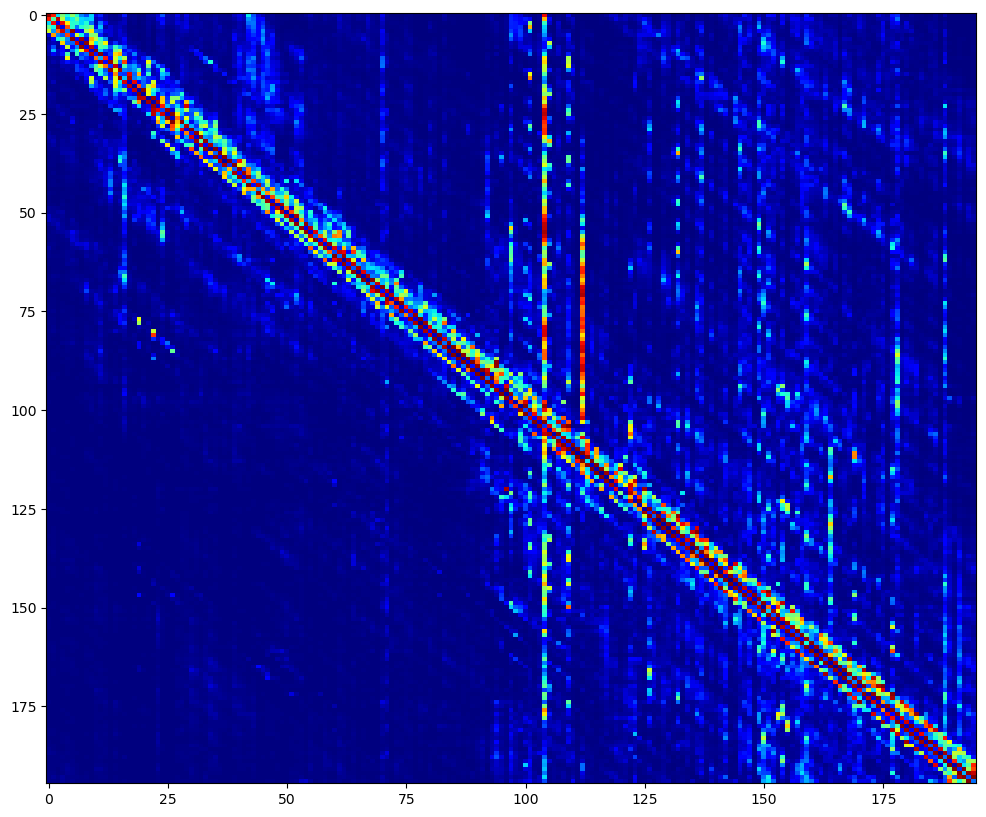

In [111]:
# Correct way to use max aggregation
attention_map_max = attentions[layer_idx].squeeze(0).max(dim=0)[0].detach().cpu().numpy()
plt.figure(figsize=(12, 10))
plt.imshow(attention_map_max, cmap='jet', aspect='auto')

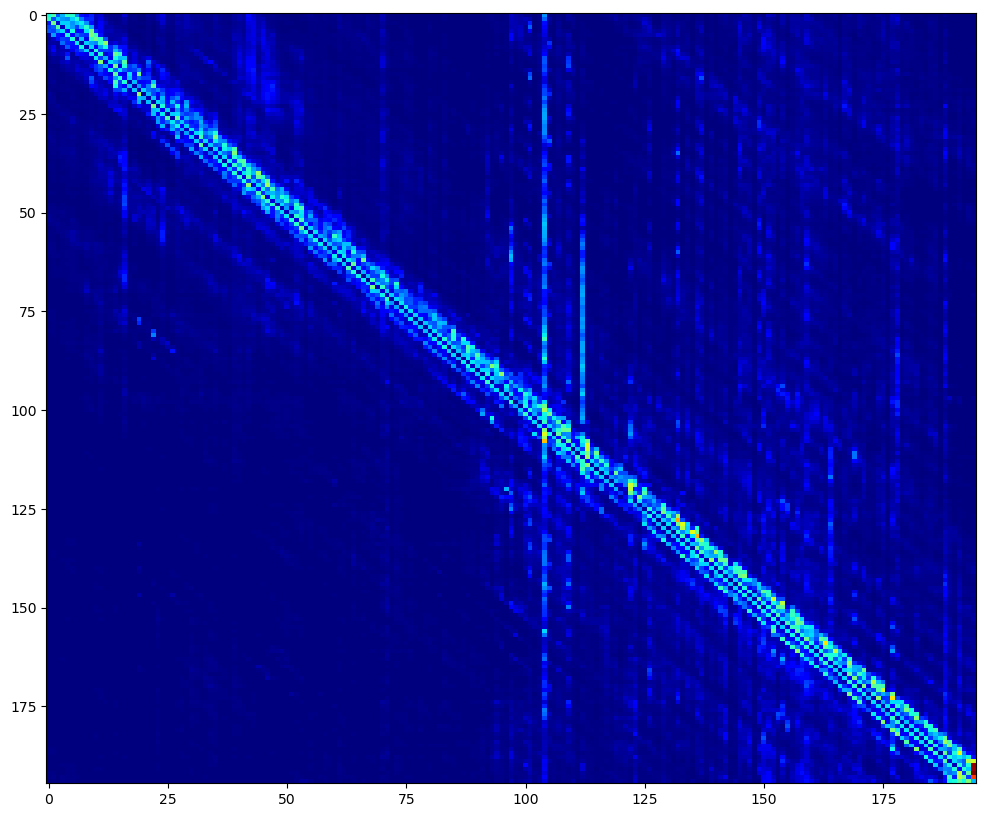

In [112]:
attention_map_mean = attentions[layer_idx].squeeze(0).mean(dim=0).detach().cpu().numpy()
plt.figure(figsize=(12, 10))
im = plt.imshow(attention_map_mean, cmap='jet', aspect='auto')

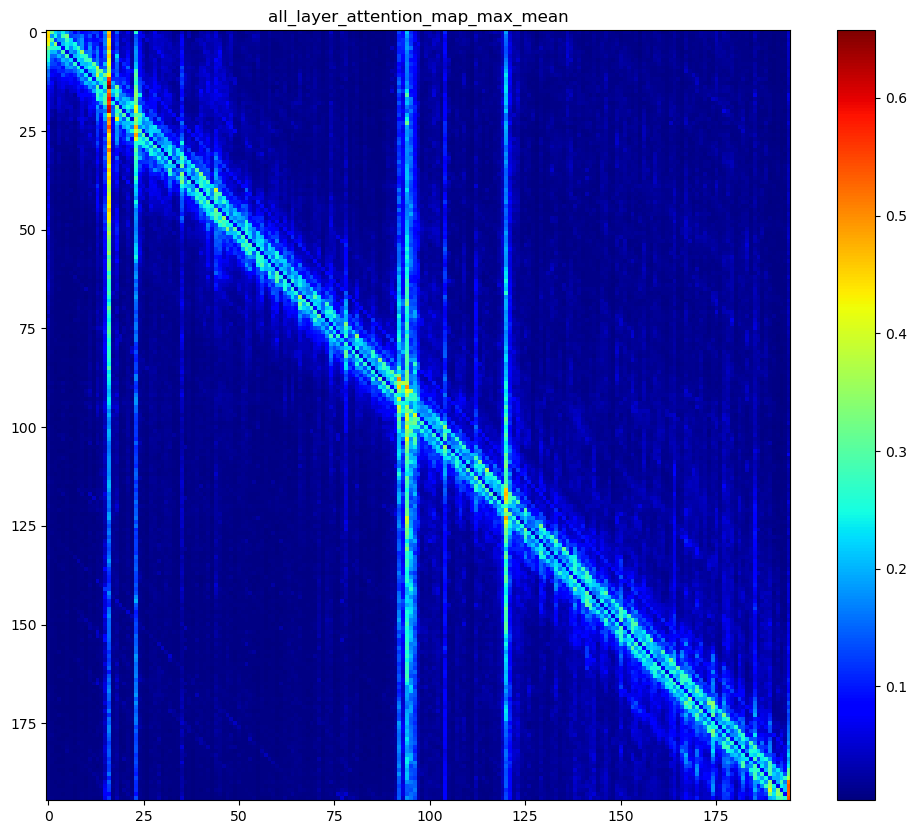

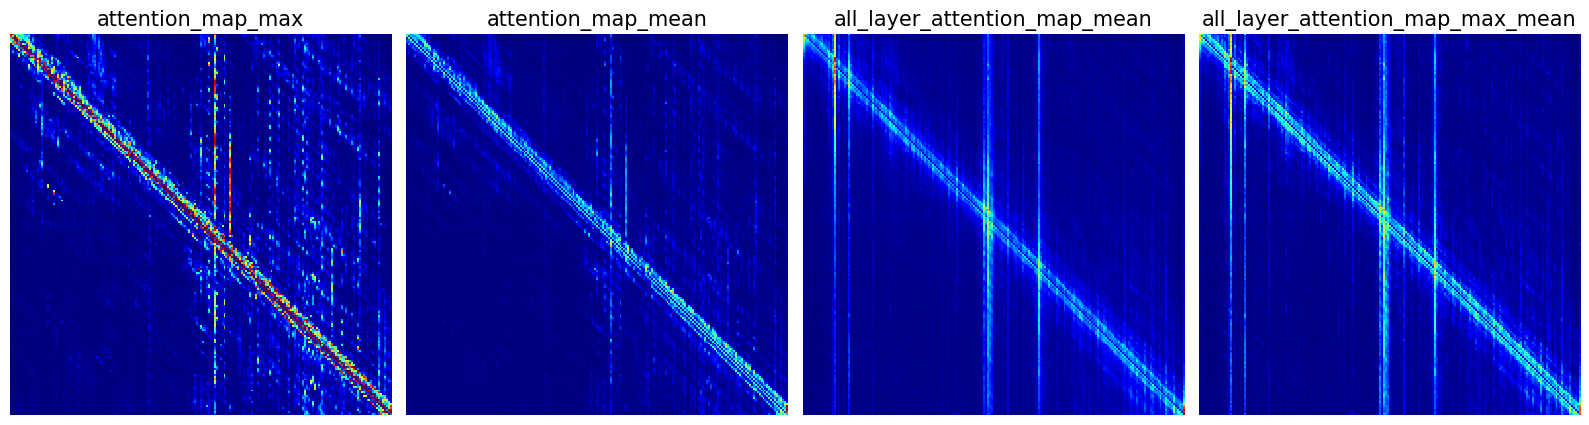

In [113]:


# Assuming attentions is a list/tensor with shape [12, 1, 20, nx, ny]
all_layers_attention = torch.stack([attentions[i] for i in range(12)]) 

# Average across layers, then across heads, then convert to numpy
all_layer_attention_map_mean = all_layers_attention.mean(dim=0).squeeze(0).mean(dim=0).detach().cpu().numpy()  # Shape: [nx, ny]
# Max across layers, mean across heads (often more balanced)
all_layer_attention_map_max_mean = all_layers_attention.max(dim=0)[0].squeeze(0).mean(dim=0).detach().cpu().numpy()
plt.figure(figsize=(12, 10))
plt.imshow(all_layer_attention_map_max_mean, cmap='viridis', aspect='auto')
plt.title('all_layer_attention_map_max_mean')
plt.colorbar()
u.show_n_images([attention_map_max,attention_map_mean,
                 all_layer_attention_map_mean, all_layer_attention_map_max_mean], 
                titles=['attention_map_max','attention_map_mean',
                 'all_layer_attention_map_mean', 'all_layer_attention_map_max_mean'],cmap='jet', axis_off='False')


### Choose attention map
> attention_map_max,

> attention_map_mean,
                 
> all_layer_attention_map_mean, 

> all_layer_attention_map_max_mean

In [114]:
attention_map=all_layer_attention_map_max_mean

In [115]:
# Define your range parameters
column_start = 60  
column_end = 120   
row_start = 60     
row_end = 120      

In [116]:
attention_map=all_layer_attention_map_max_mean

In [117]:
# Define your range parameters
column_start = 60  
column_end = 120   
row_start = 60     
row_end = 120      

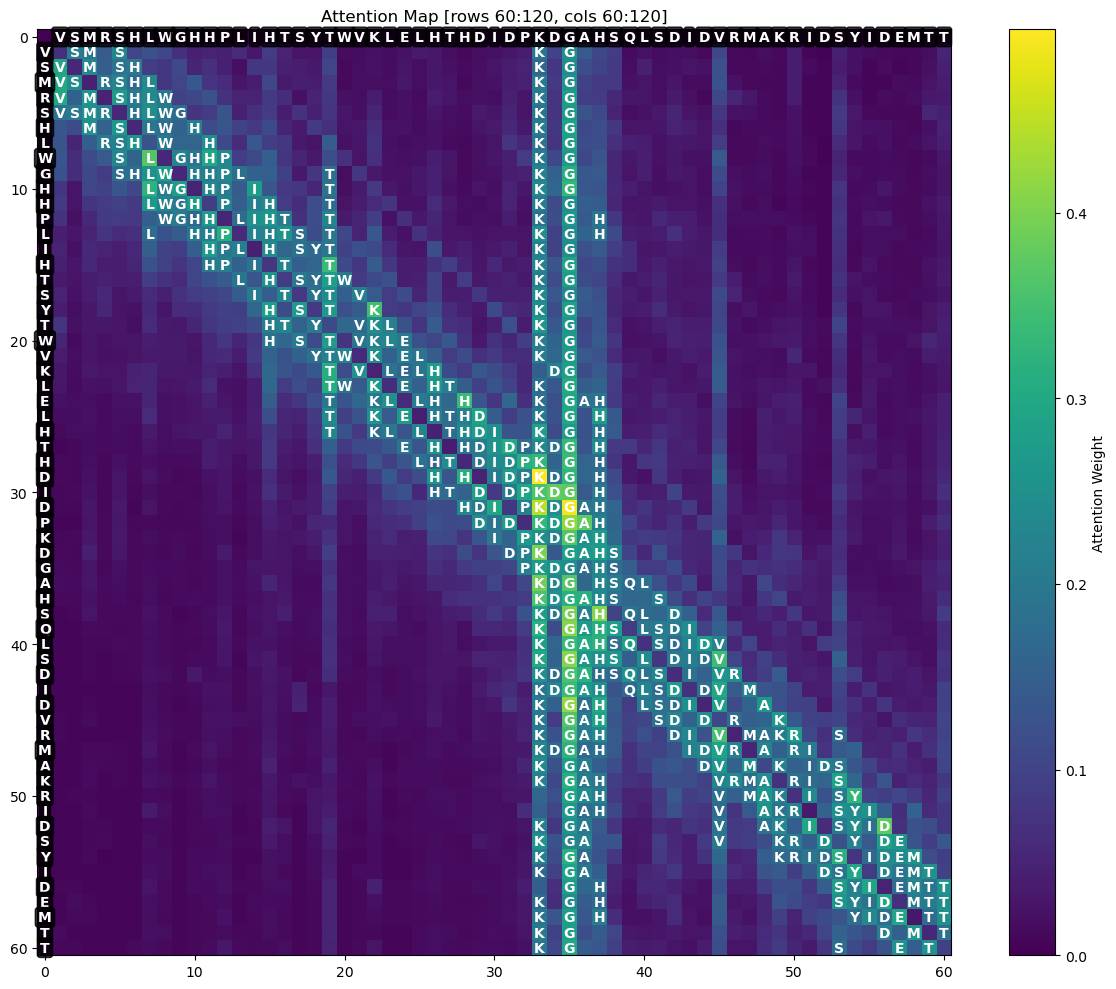

In [118]:
    

# Extract the submatrix using your specified range
sub_attention = attention_map[row_start:row_end, column_start:column_end]

# Get the corresponding sequence parts
row_sequence = sequence_1[row_start:row_end]
col_sequence = sequence_1[column_start:column_end]

#Make sure we don't exceed sequence length
max_rows = min(sub_attention.shape[0], len(row_sequence))
max_cols = min(sub_attention.shape[1], len(col_sequence))
sub_attention = sub_attention[:max_rows, :max_cols]

# Create an expanded matrix with space for labels
expanded_matrix = np.zeros((max_rows + 1, max_cols + 1))

# Fill the attention part (offset by 1 to leave space for labels)
expanded_matrix[1:max_rows+1, 1:max_cols+1] = sub_attention

plt.figure(figsize=(12, 10))
im = plt.imshow(expanded_matrix, cmap='viridis', aspect='auto')

# Add row labels (left border)
for i in range(max_rows):
    if i < len(row_sequence):
        plt.text(0, i+1, row_sequence[i], ha='center', va='center', 
                 color='white', fontsize=10, weight='bold',
                 bbox=dict(boxstyle="round,pad=0.2", facecolor="black", alpha=0.8))

# Add column labels (top border)
for j in range(max_cols):
    if j < len(col_sequence):
        plt.text(j+1, 0, col_sequence[j], ha='center', va='center', 
                 color='white', fontsize=10, weight='bold',
                 bbox=dict(boxstyle="round,pad=0.2", facecolor="black", alpha=0.8))

# Add only column characters on high attention pixels
threshold = np.percentile(sub_attention, 85)  # Top 15% of attention values
for i in range(max_rows):
    for j in range(max_cols):
        if sub_attention[i, j] > threshold and j < len(col_sequence):
            col_char = col_sequence[j]
            plt.text(j+1, i+1, col_char, ha='center', va='center', 
                    color='white', fontsize=10, weight='bold')

plt.title(f'Attention Map [rows {row_start}:{row_end}, cols {column_start}:{column_end}]')
plt.colorbar(im, label='Attention Weight')
plt.tight_layout()
plt.show()

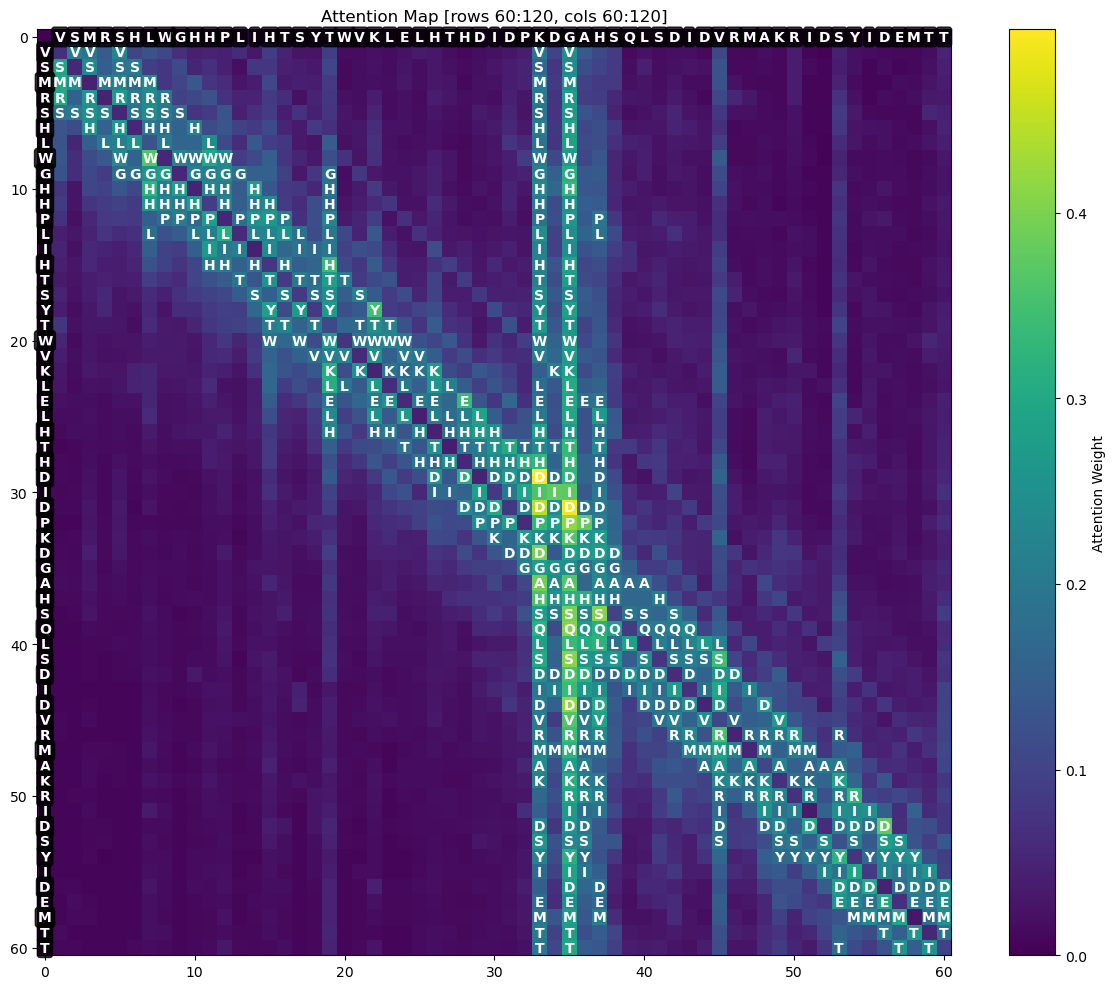

In [119]:
# Extract the submatrix using your specified range
sub_attention = attention_map[row_start:row_end, column_start:column_end]
# Get the corresponding sequence parts
row_sequence = sequence_1[row_start:row_end]
col_sequence = sequence_1[column_start:column_end]
#Make sure we don't exceed sequence length
max_rows = min(sub_attention.shape[0], len(row_sequence))
max_cols = min(sub_attention.shape[1], len(col_sequence))
sub_attention = sub_attention[:max_rows, :max_cols]
# Create an expanded matrix with space for labels
expanded_matrix = np.zeros((max_rows + 1, max_cols + 1))
# Fill the attention part (offset by 1 to leave space for labels)
expanded_matrix[1:max_rows+1, 1:max_cols+1] = sub_attention
plt.figure(figsize=(12, 10))
im = plt.imshow(expanded_matrix, cmap='viridis', aspect='auto')
# Add row labels (left border)
for i in range(max_rows):
    if i < len(row_sequence):
        plt.text(0, i+1, row_sequence[i], ha='center', va='center', 
                 color='white', fontsize=10, weight='bold',
                 bbox=dict(boxstyle="round,pad=0.2", facecolor="black", alpha=0.8))
# Add column labels (top border)
for j in range(max_cols):
    if j < len(col_sequence):
        plt.text(j+1, 0, col_sequence[j], ha='center', va='center', 
                 color='white', fontsize=10, weight='bold',
                 bbox=dict(boxstyle="round,pad=0.2", facecolor="black", alpha=0.8))
# Add only ROW characters on high attention pixels
threshold = np.percentile(sub_attention, 85)  # Top 15% of attention values
for i in range(max_rows):
    for j in range(max_cols):
        if sub_attention[i, j] > threshold and i < len(row_sequence):
            row_char = row_sequence[i]  # Changed from col_sequence[j] to row_sequence[i]
            plt.text(j+1, i+1, row_char, ha='center', va='center', 
                    color='white', fontsize=10, weight='bold')
plt.title(f'Attention Map [rows {row_start}:{row_end}, cols {column_start}:{column_end}]')
plt.colorbar(im, label='Attention Weight')
plt.tight_layout()
plt.show()

## Zoom in

In [120]:
attention_map=all_layer_attention_map_max_mean

In [121]:
attention_map=attention_map_max

In [122]:
# Define your range parameters
column_start = 0  
column_end = 50   
row_start = 0     
row_end = 50    

In [123]:
# Define your range parameters
column_start = 80  
column_end = 120   
row_start = 80     
row_end = 122    

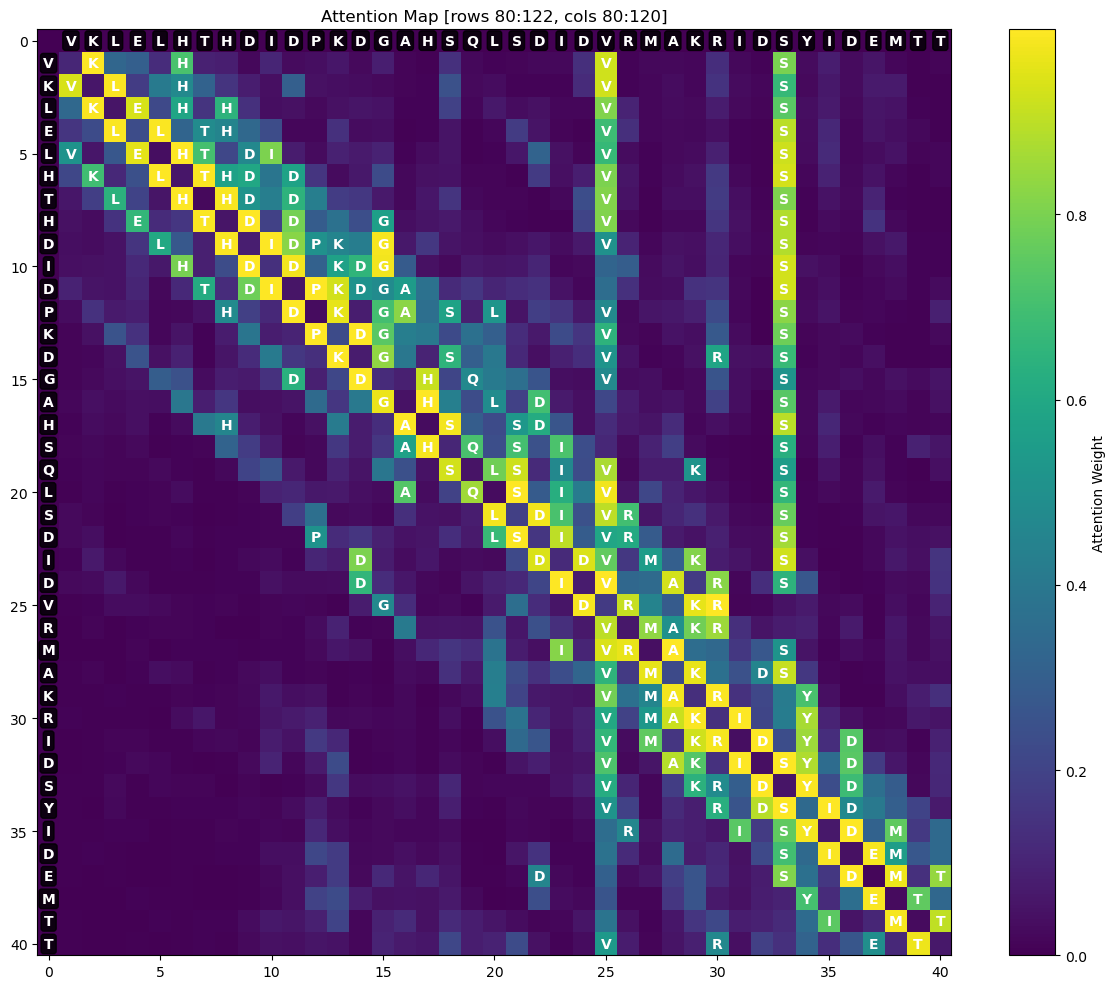

In [124]:
    

# Extract the submatrix using your specified range
sub_attention = attention_map[row_start:row_end, column_start:column_end]

# Get the corresponding sequence parts
row_sequence = sequence_1[row_start:row_end]
col_sequence = sequence_1[column_start:column_end]

#Make sure we don't exceed sequence length
max_rows = min(sub_attention.shape[0], len(row_sequence))
max_cols = min(sub_attention.shape[1], len(col_sequence))
sub_attention = sub_attention[:max_rows, :max_cols]

# Create an expanded matrix with space for labels
expanded_matrix = np.zeros((max_rows + 1, max_cols + 1))

# Fill the attention part (offset by 1 to leave space for labels)
expanded_matrix[1:max_rows+1, 1:max_cols+1] = sub_attention

plt.figure(figsize=(12, 10))
im = plt.imshow(expanded_matrix, cmap='viridis', aspect='auto')

# Add row labels (left border)
for i in range(max_rows):
    if i < len(row_sequence):
        plt.text(0, i+1, row_sequence[i], ha='center', va='center', 
                 color='white', fontsize=10, weight='bold',
                 bbox=dict(boxstyle="round,pad=0.2", facecolor="black", alpha=0.8))

# Add column labels (top border)
for j in range(max_cols):
    if j < len(col_sequence):
        plt.text(j+1, 0, col_sequence[j], ha='center', va='center', 
                 color='white', fontsize=10, weight='bold',
                 bbox=dict(boxstyle="round,pad=0.2", facecolor="black", alpha=0.8))

# Add only column characters on high attention pixels
threshold = np.percentile(sub_attention, 85)  # Top 15% of attention values
for i in range(max_rows):
    for j in range(max_cols):
        if sub_attention[i, j] > threshold and j < len(col_sequence):
            col_char = col_sequence[j]
            plt.text(j+1, i+1, col_char, ha='center', va='center', 
                    color='white', fontsize=10, weight='bold')

plt.title(f'Attention Map [rows {row_start}:{row_end}, cols {column_start}:{column_end}]')
plt.colorbar(im, label='Attention Weight')
plt.tight_layout()
plt.show()

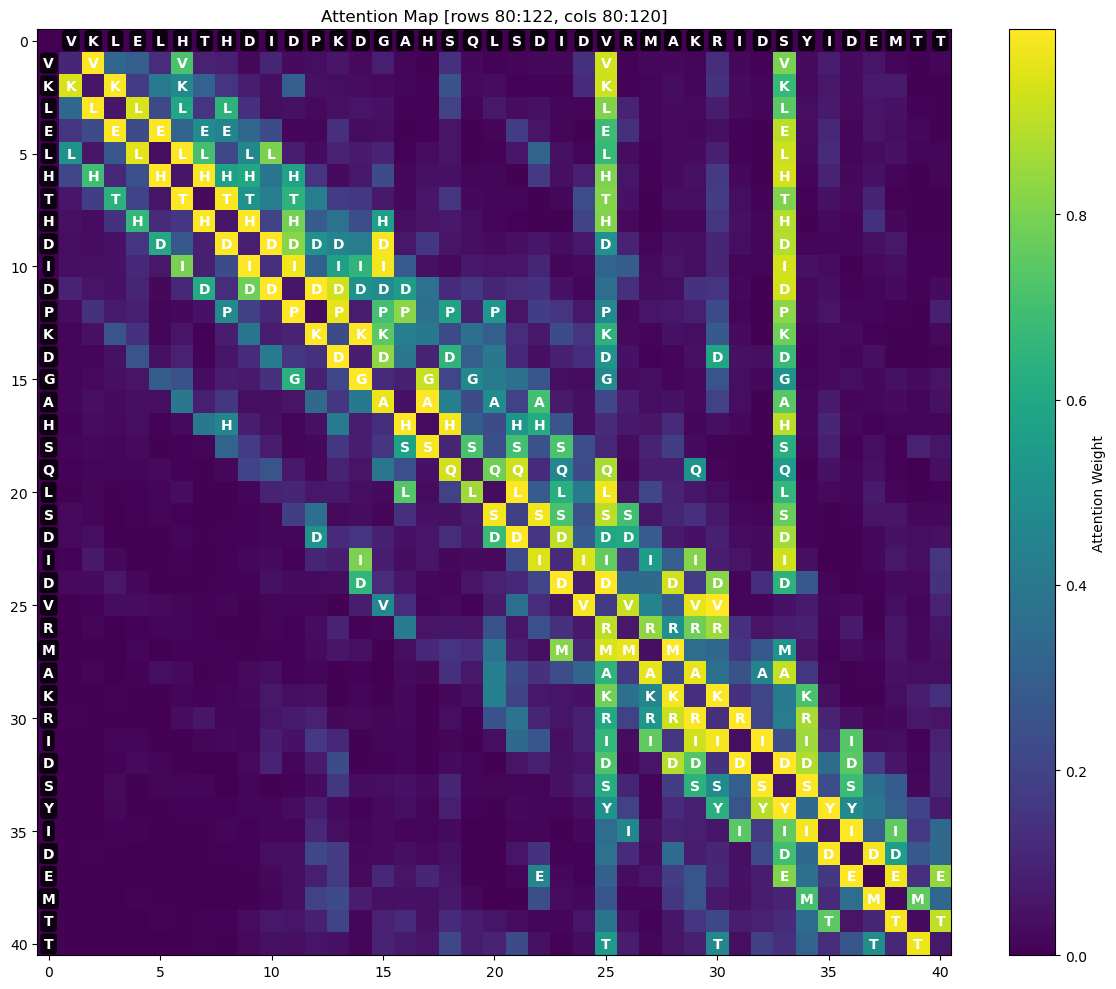

In [125]:
# Extract the submatrix using your specified range
sub_attention = attention_map[row_start:row_end, column_start:column_end]
# Get the corresponding sequence parts
row_sequence = sequence_1[row_start:row_end]
col_sequence = sequence_1[column_start:column_end]
#Make sure we don't exceed sequence length
max_rows = min(sub_attention.shape[0], len(row_sequence))
max_cols = min(sub_attention.shape[1], len(col_sequence))
sub_attention = sub_attention[:max_rows, :max_cols]
# Create an expanded matrix with space for labels
expanded_matrix = np.zeros((max_rows + 1, max_cols + 1))
# Fill the attention part (offset by 1 to leave space for labels)
expanded_matrix[1:max_rows+1, 1:max_cols+1] = sub_attention
plt.figure(figsize=(12, 10))
im = plt.imshow(expanded_matrix, cmap='viridis', aspect='auto')
# Add row labels (left border)
for i in range(max_rows):
    if i < len(row_sequence):
        plt.text(0, i+1, row_sequence[i], ha='center', va='center', 
                 color='white', fontsize=10, weight='bold',
                 bbox=dict(boxstyle="round,pad=0.2", facecolor="black", alpha=0.8))
# Add column labels (top border)
for j in range(max_cols):
    if j < len(col_sequence):
        plt.text(j+1, 0, col_sequence[j], ha='center', va='center', 
                 color='white', fontsize=10, weight='bold',
                 bbox=dict(boxstyle="round,pad=0.2", facecolor="black", alpha=0.8))
# Add only ROW characters on high attention pixels
threshold = np.percentile(sub_attention, 85)  # Top 15% of attention values
for i in range(max_rows):
    for j in range(max_cols):
        if sub_attention[i, j] > threshold and i < len(row_sequence):
            row_char = row_sequence[i]  # Changed from col_sequence[j] to row_sequence[i]
            plt.text(j+1, i+1, row_char, ha='center', va='center', 
                    color='white', fontsize=10, weight='bold')
plt.title(f'Attention Map [rows {row_start}:{row_end}, cols {column_start}:{column_end}]')
plt.colorbar(im, label='Attention Weight')
plt.tight_layout()
plt.show()